In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

%matplotlib inline

First, we have to decide how to deal with longitudinality. For now, we will ignore longitudinal data and treat each row as a unique patient. This means we need to take out any 'baseline' data.

In [2]:
df = pd.read_csv('ADNIMERGE.csv')
all_cols = list(df)
df.dtypes

# baseline data is indicated by '_bl' OR described as a baseline measurement in ADNIMERGE_DICT
important_cols = [i for i in all_cols[9:-3] if i[-2:] != 'bl']

In [3]:
important_cols = ['RID'] + important_cols

In [4]:
data = df[important_cols]

`AGE` is probably an important predictor for a diagnosis. However, ADNIMERGE_DICT says that `AGE` is the age of the patient at baseline. Because we are treating each row as a separate patient, we should use `Month_bl` (months from baseline) to calculate a 'new age' for each row. That is, a 65 year old who gets a second exam 12 months later will be treated as a different, 66 year old person.

In [5]:
data['EXACT_AGE'] = df.AGE + (df.Month_bl/12)

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
# now we need to one-hot encode the categorical predictors
# BUT since we will eventually do a classification with DX,
# we'll first convert those values and then one-hot encode
# things like marriage, etc

DX_class = []
for i in data.DX.values:
    if i == 'CN':
        DX_class.append(0)
    elif i == 'MCI':
        DX_class.append(1)
    elif i == 'Dementia':
        DX_class.append(2)
    else:
        DX_class.append(i) # for NaNs. will deal with missingness next.

# now drop the original DX column
data.drop('DX',axis=1,inplace=True)

# and replace with the new DX_class column
data['DX_class'] = DX_class

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# get columns with categorical data
# by finding columns that have strings as entries
cat_cols = [i for i in data.columns if isinstance(data[i][0], str)]
# cat_cols = cat_cols + ['DX_class']

In [8]:
# choosing to drop first because that was the 
# suggested best practice in HW3
data_hot = pd.get_dummies(data, columns = cat_cols, drop_first = True)

In [9]:
data_hot.shape

(13017, 54)

Now we need to deal with missingness.

In [10]:
# what percent of each column is missing?
def percent_in_each_col(df):
    percent_missing = [df[i].isnull().mean()*100 for i in list(df)]
    percent_missing = np.asarray(percent_missing)
    in_each = pd.DataFrame(percent_missing,df.columns,columns=["Percent"])
    print(in_each[in_each.Percent > 0])
    print("Average percent missing for all columns: ", in_each[in_each.Percent > 0].mean())


In [11]:
percent_in_each_col(data_hot)

                         Percent
APOE4                   0.453253
FDG                    74.241377
PIB                    98.286856
AV45                   83.398633
CDRSB                  30.736729
ADAS11                 31.174618
ADAS13                 31.835292
MMSE                   29.522932
RAVLT_immediate        30.383345
RAVLT_learning         30.383345
RAVLT_forgetting       30.583084
RAVLT_perc_forgetting  31.120842
FAQ                    29.000538
MOCA                   60.052239
EcogPtMem              59.360836
EcogPtLang             59.483752
EcogPtVisspat          59.798725
EcogPtPlan             59.560575
EcogPtOrgan            60.382577
EcogPtDivatt           59.798725
EcogPtTotal            59.453023
EcogSPMem              59.099639
EcogSPLang             59.061228
EcogSPVisspat          59.829454
EcogSPPlan             59.545210
EcogSPOrgan            60.866559
EcogSPDivatt           60.121380
EcogSPTotal            59.099639
Ventricles             42.790197
Hippocampu

Some of the features have more than 50% of the data missing. This is because some tests were not used during certain protocols (ADNI1 vs ADNIGO, for example). Not sure exactly how to deal with that. Right now, we're just going to impute values for all the missing data, and see where that gets us.

In [12]:
# In lecture, Kevin mentioned that imputing using the median
# will often give you the best results

from sklearn.preprocessing import Imputer

imp = Imputer(strategy="median")
imputed = imp.fit_transform(data_hot)
full_data = pd.DataFrame(imputed,columns = data_hot.columns)

percent_in_each_col(full_data)

Empty DataFrame
Columns: [Percent]
Index: []
Average percent missing for all columns:  Percent   NaN
dtype: float64


In [13]:
full_data.head()

,RID,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,...,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,FLDSTRENG_3 Tesla MRI,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)
0,2.0,16.0,0.0,1.36926,1.85,1.11467,0.0,10.67,18.67,28.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.0,18.0,1.0,1.09079,1.85,1.11467,4.5,22.00,31.00,20.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3.0,18.0,1.0,1.06360,1.85,1.11467,6.0,19.00,30.00,24.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,18.0,1.0,1.10384,1.85,1.11467,3.5,24.00,35.00,17.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,18.0,1.0,1.03871,1.85,1.11467,8.0,25.67,37.67,19.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Now, we want to run a few different types of regressions on this 'full' data set using each cognitive test as a response variable. We'll create a matrix of R^2 values, and use that to decide which model should be used as our 'meta test'. **ALSO**: should we be standardizing the continuous variables??

In [14]:
def split_and_score(df, response_col_name, model):
    # returns TEST score based on model fitted to data with specified response var
    # response_col_name is a string
    # model is an unfitted sklearn model
    # would be nice to add a polynomial features option
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < .75
    
    train = df[msk]
    test = df[~msk]
        
    predictors = [i for i in df.columns[1:] if i not in response_col_name]
    x = train[predictors]
    y = train[response_col_name]
    
    Xt = test[predictors]
    yt = test[response_col_name]        
    
    model.fit(x,y)
    test_score = model.score(Xt, yt)
    return test_score 

In [15]:
def make_score_df(df,response_vars,model_dict):
    # returns a dataframes of TEST r^2 values
    # response_vars is a list of strings
    # model_dict is a dictionary of unfitted sklearn models
    
    keys = list(model_dict.keys())
    scores = np.zeros((len(response_vars),len(keys)))
    
    for col, model in enumerate(keys):
        for row, response in enumerate(response_vars):
            scores[row,col] = split_and_score(df,response,model_dict[model])
   
    score_df = pd.DataFrame(scores,columns=[keys],index=response_vars)

    return score_df
    

In [16]:
cog_tests = ['ADAS13','CDRSB','MOCA','MMSE','RAVLT_perc_forgetting','FAQ','ADAS11',"EcogPtTotal",'EcogSPTotal']

models = {}
models['KNN'] = KNeighborsRegressor(n_neighbors = 25)
models['LinearRegression'] = LinearRegression(fit_intercept = True)
models['Ridge'] = RidgeCV()
models['Lasso'] = LassoCV()
models['RandomForest'] = RandomForestRegressor()
models['DecisionTree'] = DecisionTreeRegressor()

In [17]:
poop = make_score_df(full_data,cog_tests,models)

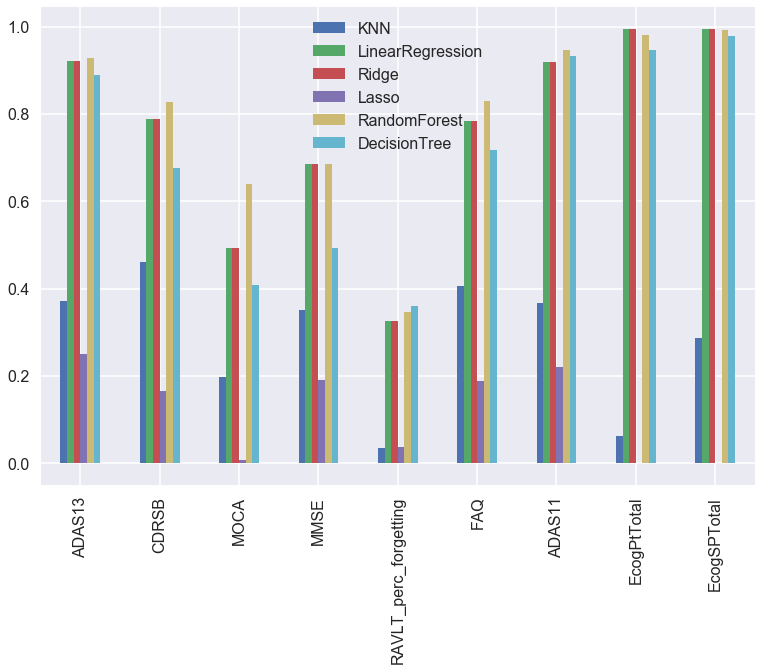

In [18]:
sns.set_context("poster")
poop.plot(kind="bar")

In [19]:
poop

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.370575,0.920684,0.920670,0.249385,0.927926,0.889698
CDRSB,0.461899,0.788965,0.788952,0.165541,0.827817,0.677024
MOCA,0.197120,0.493442,0.493475,0.007704,0.638813,0.408791
MMSE,0.351756,0.684854,0.684950,0.190285,0.686197,0.492026
RAVLT_perc_forgetting,0.035105,0.325546,0.324882,0.036130,0.345215,0.361106
FAQ,0.405214,0.783359,0.783136,0.187249,0.829880,0.716532
ADAS11,0.367270,0.919964,0.920025,0.219364,0.947112,0.933235
EcogPtTotal,0.062392,0.994702,0.994683,-0.000713,0.982113,0.947330
EcogSPTotal,0.287788,0.996034,0.996000,-0.000169,0.992946,0.978392


NEW PLAN: We got *really* good results from: 

(EcogPt, LinReg), (EcogPt, Ridge), (EcogPt, RandomForest)

(EcogSP, LinReg), (EcogSP, Ridge), (EcogSP, RandomForest)

(ADAS11, RandomForest)

SO: strategy is to create a meta test based on each pairing, then combine all of those into a meta meta test, weighting each meta test by the test R^2 values

In [20]:
# create the new meta-test feature
# I *think* to do this, we'll need to test/train on a subset of the data
# then predict on the whole 'full_data' (????? this seems wrong as we would be 
# double using data but not sure how else to do this)

def create_meta_test(df,model,response):
    # create subset
    np.random.seed(9001)
    meta_msk = np.random.rand(len(df)) < .5
    small = df[meta_msk]
    
    # train test split
    np.random.seed(9001)
    msk = np.random.rand(len(small)) < .75
    train = small[msk]
    test = small[~msk]
    
    predictors = [i for i in full_data.columns[1:] if i not in response]

    x = train[predictors]
    y = train[response]

    Xt = test[predictors]
    yt = test[response]
    
    # set to make the final predictions on
    x_final = df[predictors]
    
    model.fit(x,y)
    meta_test = model.predict(x_final)
    
    return meta_test
    

In [21]:
tests = ['EcogPtTotal','EcogSPTotal','ADAS11']

meta_models = {}
meta_models["RandomForest"] = RandomForestRegressor()
meta_models["LinearRegression"] = LinearRegression()
meta_models["Ridge"] = RidgeCV()

models = (meta_models.keys())

meta_dict = {}

for m in models:
    for t in tests:
        meta_dict[t+m] = create_meta_test(full_data,meta_models[m],t)

meta_dict.keys()

dict_keys(['EcogPtTotalRandomForest', 'EcogSPTotalRandomForest', 'ADAS11RandomForest', 'EcogPtTotalLinearRegression', 'EcogSPTotalLinearRegression', 'ADAS11LinearRegression', 'EcogPtTotalRidge', 'EcogSPTotalRidge', 'ADAS11Ridge'])

In [22]:
del meta_dict['ADAS11LinearRegression']

In [23]:
del meta_dict['ADAS11Ridge']

In [24]:
# create df of the seven meta tests
meta_tests_df = pd.DataFrame(meta_dict)
meta_tests_df.head()

,ADAS11RandomForest,EcogPtTotalLinearRegression,EcogPtTotalRandomForest,EcogPtTotalRidge,EcogSPTotalLinearRegression,EcogSPTotalRandomForest,EcogSPTotalRidge
0,11.369,1.525853,1.538461,1.532700,1.477690,1.48718,1.470555
1,20.600,1.537251,1.538461,1.542571,1.488050,1.48718,1.482623
2,18.467,1.537252,1.538461,1.542301,1.498710,1.48718,1.493573
3,22.434,1.532831,1.538461,1.537567,1.477171,1.48718,1.471484
4,25.667,1.534719,1.538461,1.539524,1.493021,1.48718,1.487602


In [25]:
poop

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.370575,0.920684,0.920670,0.249385,0.927926,0.889698
CDRSB,0.461899,0.788965,0.788952,0.165541,0.827817,0.677024
MOCA,0.197120,0.493442,0.493475,0.007704,0.638813,0.408791
MMSE,0.351756,0.684854,0.684950,0.190285,0.686197,0.492026
RAVLT_perc_forgetting,0.035105,0.325546,0.324882,0.036130,0.345215,0.361106
FAQ,0.405214,0.783359,0.783136,0.187249,0.829880,0.716532
ADAS11,0.367270,0.919964,0.920025,0.219364,0.947112,0.933235
EcogPtTotal,0.062392,0.994702,0.994683,-0.000713,0.982113,0.947330
EcogSPTotal,0.287788,0.996034,0.996000,-0.000169,0.992946,0.978392


In [26]:
meta_tests_df.ADAS11RandomForest = meta_tests_df.ADAS11RandomForest*poop.RandomForest[6]
meta_tests_df.EcogPtTotalRandomForest = meta_tests_df.EcogPtTotalRandomForest*poop.RandomForest[7]
meta_tests_df.EcogSPTotalRandomForest = meta_tests_df.EcogSPTotalRandomForest*poop.RandomForest[8]

meta_tests_df.EcogPtTotalLinearRegression = meta_tests_df.EcogPtTotalLinearRegression*poop.LinearRegression[7]
meta_tests_df.EcogSPTotalLinearRegression = meta_tests_df.EcogSPTotalLinearRegression*poop.LinearRegression[8]

meta_tests_df.EcogPtTotalRidge = meta_tests_df.EcogPtTotalRidge*poop.Ridge[7]
meta_tests_df.EcogSPTotalRidge = meta_tests_df.EcogSPTotalRidge*poop.Ridge[8]

In [27]:
FinalMetaTest = meta_tests_df.sum(axis=1)

In [28]:
full_data['MetaTest'] = FinalMetaTest

Now, we have a combined meta meta test. We'll compare some classification models.

In [53]:
# create df of just meta test and the dx_class
meta_dx = full_data[['MetaTest','DX_class']]

# train test split
np.random.seed(9001)
msk = np.random.rand(len(meta_dx)) < .75
train = meta_dx[msk]
test = meta_dx[~msk]

x = train['MetaTest'].values.reshape(-1,1)
y = train['DX_class']

Xt = test['MetaTest'].values.reshape(-1,1)
yt = test['DX_class']

In [54]:
# Logistic Regression

logit = LogisticRegressionCV(multi_class='multinomial')
logit.fit(x,y)
logit.score(Xt,yt)

0.7809878844361603

In [55]:
# RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x,y)
rfc.score(Xt,yt)

0.71606088847468152

In [56]:
# logistic with quad terms
poly = PolynomialFeatures(degree = 2)
x_poly = poly.fit_transform(x)
Xt_poly = poly.fit_transform(Xt)

log_poly = LogisticRegressionCV(multi_class='multinomial')
log_poly.fit(x_poly,y)
log_poly.score(Xt_poly,yt)

0.78347312830071447

Looks like the logistic regression gives us the best results (Patrick hinted at this). Check class accuracies:

In [57]:
from sklearn import metrics
def conf_mat(model,x,y,name):
    # model must be fitted to training data before calling this function
    # x and y should be test
    yp = model.predict(x)
    m = metrics.confusion_matrix(y, yp)
    cn_acc = m[0,0]/np.sum(m[0])
    mci_acc = m[1,1]/np.sum(m[1])
    ad_acc = m[2,2]/np.sum(m[2])
    print(name)
    print("CN Class Accuracy: %f\nMCI Class Accuracy: %f\nAD Class Accuracy: %f\n"%(cn_acc,mci_acc,ad_acc))

In [58]:
conf_mat(logit,Xt,yt,"Logistic Regression")
conf_mat(rfc,Xt,yt,"Random Forest")
conf_mat(log_poly,Xt_poly,yt,"Logistic Regression with Quad Terms")

Logistic Regression
CN Class Accuracy: 0.528889
MCI Class Accuracy: 0.897117
AD Class Accuracy: 0.661654

Random Forest
CN Class Accuracy: 0.598519
MCI Class Accuracy: 0.779821
AD Class Accuracy: 0.624060

Logistic Regression with Quad Terms
CN Class Accuracy: 0.557037
MCI Class Accuracy: 0.886680
AD Class Accuracy: 0.680451



/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


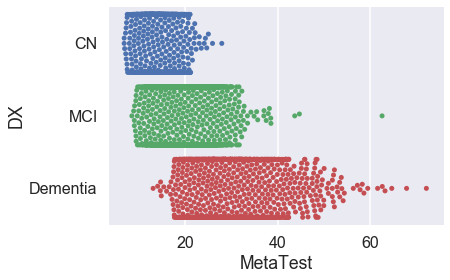

In [38]:
sns.set_context()
meta_dx['DX'] = df.DX
sns.swarmplot(x="MetaTest", y="DX", data=meta_dx.head(1000),order=['CN','MCI','Dementia'])


In [60]:
meta_dx.head()

,MetaTest,DX_class
0,19.734171,0.0
1,28.520454,2.0
2,26.521521,2.0
3,30.226154,2.0
4,33.323832,2.0


In [61]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [64]:
ada.score(Xt,yt)
conf_mat(ada,Xt,yt,"Ada")
conf_mat(logit,Xt,yt,"Logistic Regression")
conf_mat(rfc,Xt,yt,"Random Forest")
conf_mat(log_poly,Xt_poly,yt,"Logistic Regression with Quad Terms")

Ada
CN Class Accuracy: 0.662222
MCI Class Accuracy: 0.829026
AD Class Accuracy: 0.757519

Logistic Regression
CN Class Accuracy: 0.528889
MCI Class Accuracy: 0.897117
AD Class Accuracy: 0.661654

Random Forest
CN Class Accuracy: 0.598519
MCI Class Accuracy: 0.779821
AD Class Accuracy: 0.624060

Logistic Regression with Quad Terms
CN Class Accuracy: 0.557037
MCI Class Accuracy: 0.886680
AD Class Accuracy: 0.680451



In [66]:
dx_preds = ada.predict(meta_dx.MetaTest.values.reshape(-1,1))

In [67]:
meta_dx['Preds'] = dx_preds

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


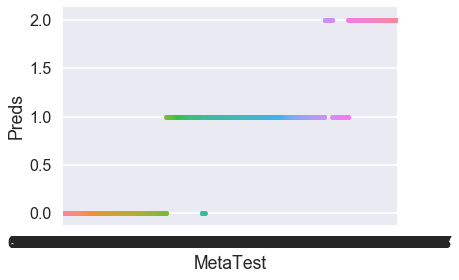

In [70]:
sns.swarmplot(x="MetaTest", y="Preds", data=meta_dx.head(1000))

In [69]:
dx_preds

array([ 1.,  2.,  2., ...,  1.,  1.,  1.])

In [71]:
pred_class=[]
for i in meta_dx.Preds.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')


In [72]:
meta_dx['Preds'] = pred_class

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
sns.set_context("poster")
# sns.swarmplot(x="MetaTest", y="Preds",hue="DX", data=meta_dx.head(1000),order=['CN','MCI','Dementia'])

In [79]:
meta_dx['DX'] = df.DX

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


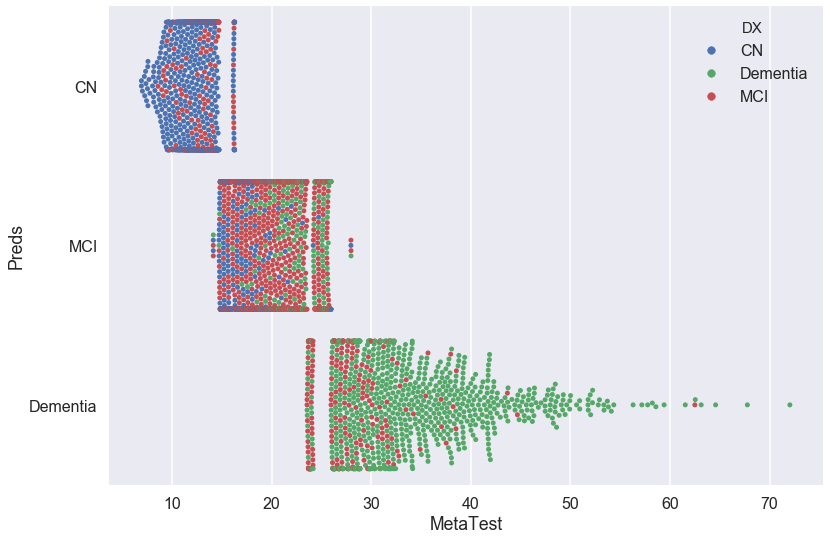

In [81]:
sns.swarmplot(x="MetaTest", y="Preds",hue="DX", data=meta_dx.head(5000),order=['CN','MCI','Dementia'])

In [86]:
mci_df = full_data[full_data.MetaTest > 10]

In [87]:
mci_df = mci_df[mci_df.MetaTest < 25]
mci_df.head()

,RID,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,...,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,FLDSTRENG_3 Tesla MRI,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),MetaTest
0,2.0,16.0,0.0,1.36926,1.85,1.11467,0.0,10.67,18.67,28.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,19.734171
5,4.0,10.0,0.0,1.21987,1.85,1.11467,1.0,14.33,21.33,27.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,20.481521
6,4.0,10.0,0.0,1.21987,1.85,1.11467,0.5,17.33,25.33,28.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,23.618010
7,4.0,10.0,0.0,1.21987,1.85,1.11467,1.0,15.00,22.00,26.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,20.635381
9,4.0,10.0,0.0,1.21987,1.85,1.11467,1.0,18.00,25.00,25.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,24.446722


In [89]:
cog_tests = ['ADAS13','CDRSB','MOCA','MMSE','RAVLT_perc_forgetting','FAQ','ADAS11',"EcogPtTotal",'EcogSPTotal']

models = {}
models['KNN'] = KNeighborsRegressor(n_neighbors = 25)
models['LinearRegression'] = LinearRegression(fit_intercept = True)
models['Ridge'] = RidgeCV()
models['Lasso'] = LassoCV()
models['RandomForest'] = RandomForestRegressor()
models['DecisionTree'] = DecisionTreeRegressor()

mci_r2 = make_score_df(mci_df,cog_tests,models)
mci_r2

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.193845,0.960849,0.960859,0.167560,0.940096,0.889354
CDRSB,0.399821,0.681809,0.687263,0.070408,0.705414,0.477756
MOCA,0.145062,0.292180,0.291065,0.005842,0.425785,-0.133825
MMSE,0.104803,0.424338,0.425189,0.100952,0.386476,-0.053024
RAVLT_perc_forgetting,0.152110,0.874283,0.874479,0.095987,0.826501,0.844597
FAQ,0.279184,0.693185,0.692318,0.053460,0.703194,0.461030
ADAS11,0.175493,0.882123,0.882535,0.117620,0.853516,0.777306
EcogPtTotal,0.080551,0.997312,0.997329,0.003843,0.977455,0.930256
EcogSPTotal,0.256917,0.990825,0.989168,-0.000156,0.978436,0.950463


In [90]:
np.random.seed(9001)
msk = np.random.rand(len(mci_df)) < .75
train2 = mci_df[msk]
test2 = mci_df[~msk]

x2 = train2['ADAS13'].values.reshape(-1,1)
y2 = train2['DX_class']

Xt2 = test2['ADAS13'].values.reshape(-1,1)
yt2 = test2['DX_class']

In [91]:
ada.fit(x2,y2)
conf_mat(ada,Xt2,yt2,"Ada")

Ada
CN Class Accuracy: 0.628333
MCI Class Accuracy: 0.874866
AD Class Accuracy: 0.000000



In [94]:
mci_preds = ada.predict(mci_df.ADAS13.values.reshape(-1,1))

In [101]:
mci_df['ADAS13Preds'] = mci_preds
pred_class=[]
for i in mci_df.ADAS13Preds.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')
mci_df['ADAS13Preds'] = pred_class

In [102]:
pred_class=[]
for i in mci_df.DX_class.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')
mci_df['DX_class'] = pred_class

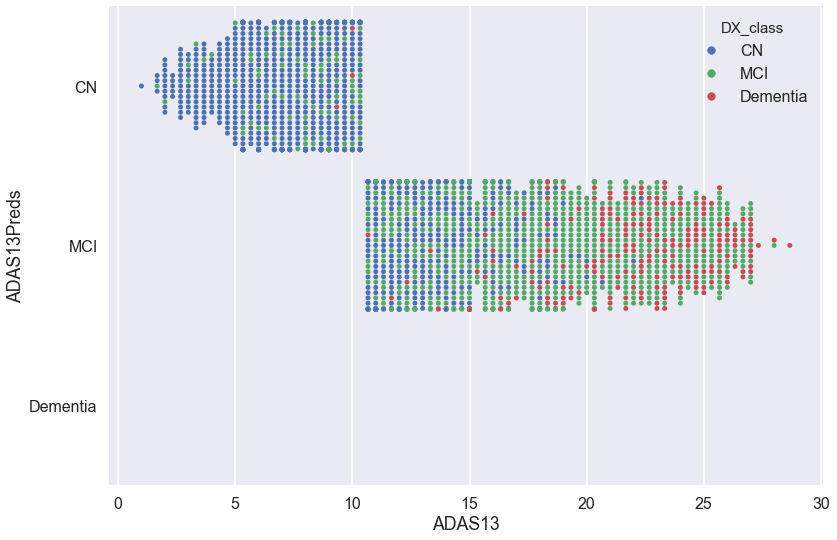

In [109]:
sns.swarmplot(x="ADAS13", y="ADAS13Preds",hue="DX_class", data=mci_df.head(2000),order=['CN','MCI','Dementia'])

In [107]:
mci_df.shape

(10470, 56)

SO the general rule is: first look at meta test (First swarm plot). If score is < 10 then CN. If score is > 25, then Dementia. If 10 < score < 25, then look at ADAS13.

Then 0-8 = CN, 8-20 is MCI, 20+ is Dementia